# Flooding stage 2 basin evolution - Western Mediterranean (wMed)

#### Here we compute the evolution of the mixing depth, mixed-layer salinity and density during the stage 2 of wMed flooding.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import pandas as pd
import gsw

## Upload data files here


In [2]:
KE             = np.loadtxt(fname="wMed_flow_KE.txt")             # Flow energy entering the wMed (From Script 1)
BPEad_wMed     = np.loadtxt(fname="wMed_added_BPE_Stage2.txt")    # Added BPE to wMed during stage 2 (From Script 3)
SLrise_wMed    = np.loadtxt(fname="SL_rise_wMed.txt")             # Rise of wMed level (From Script 1)
Discharge      = np.loadtxt(fname="Discharge.txt")                # Flow discharge (From Script 1)
Inflow_bottom  = np.loadtxt(fname="wMed_Stage2_inflowBottom.txt") # Daily bottom depths of added seawater layer 
Hypsometrywmed = np.loadtxt(fname="Hypsometry_wMed_CalcBPE.txt")

## Setting parameters

(1027, 1080)

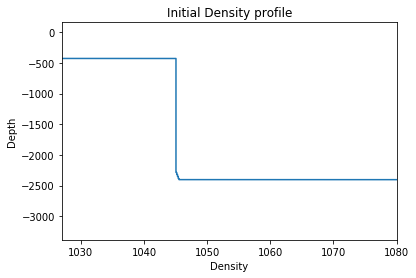

In [4]:
rho_SW   = 1027   # Inflowing sea-water density [kg m^-3]
g        = 9.81   # Acceleration due to gravity [m s^-2]
S_Marine = 36.5   # Atlantic water salinity [PSU]
T_Brine  = 20     # Brine temperature [degrees Celcius]
Mix_Ef   = 0.2    # Mixing efficiency

dzArray  = np.linspace(0.5,3223.5,3224)  # Creates an array of mid-layer depths

Depth     = Hypsometrywmed[:,0]  # Reconstructed wMed hypsometry
DepthList = Depth.tolist()

Area =(Hypsometrywmed[:,1])*10**12         # Gives wMed area with depth from surface towards bottom
Vol  = (Hypsometrywmed[:,3])*10**12        # Gives the cumulative volume in WMed from surface towards bottom
Volfrombot = (Hypsometrywmed[:,2])*10**12  # Gives the cumulative volume in WMed from bottom towards surface

DensityS2 = np.loadtxt(fname="wMed_DprofileStage1-20.txt") # Uploads the density profile at the stage 1 termination
SalinityS2= np.loadtxt(fname="wMed_SprofileStage1-20.txt") # Uploads the salinity profile at the stage 1 termination
plt.figure()
plt.title('Initial Density profile')
plt.ylabel('Depth')
plt.xlabel('Density')
plt.plot(DensityS2,-Depth)
plt.xlim([rho_SW,1080])

<img src="https://www.dropbox.com/s/bjqvd1nat3iwr30/BPE_Calc_stage2.jpg?raw=1" width="749.7" height="379.4">


## Calculating wMed evolution parameters for stage 2

Here we use the same concept as in stage 1. Basin level is kept constant at Sicily sill level.
Each day, a seawater layer replaces wMed mixed fluids (which subsequently transferred to eMed)

NOW Profile_000400.txt
NOW Profile_000500.txt


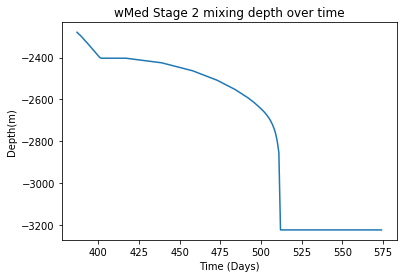

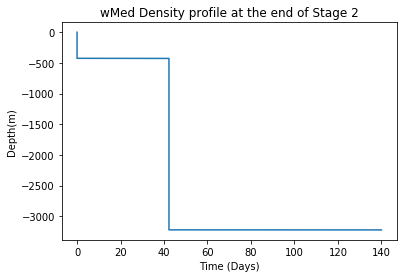

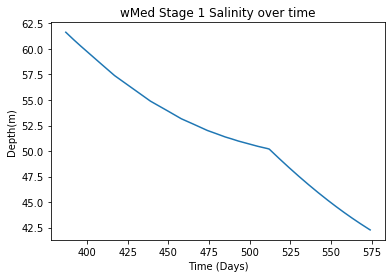

In [8]:
t = 387   # Starting time stage 2    
SL_Sicily = 426  # Sicily sill level set to 426 m, as in the end of day 386 (stage 1 end), basin fills up to this level. 
                 # For simplicity, we consider this to be stage 2 initiation (As we compute daily basin evolution)
                 # Effect on the final answer of assuming sill depth to be 426 m (not 430 m) is neglegible.
        
BotTrunc = np.trunc(Inflow_bottom)  # Array of bottom depths (truncated) of the seawater layer which replaced wMed mixed fluids
KEAv = KE*Mix_Ef  # Available kinetic energy

# Setting arrays used for calculations and plotting

MixedD_wMed = [1044.9988588226531  ] # Mixed layer density at the end of stage 1
MixedS_wMed = [61.69853572327281]    # Mixed layer density at the end of stage 1
Mdepth_wMed = []        # Appends daily mixing depth [m]
Times        = []       # Appends time [days]
D_profile    = []       # Appends final density profile at the end of stage 1
S_profile    = []       # Appends final salinity profile at the end of stage 1

DensityS2 = np.loadtxt(fname="wMed_DprofileStage1-20.txt") # Uploads the density profile at the stage 1 termination
SalinityS2= np.loadtxt(fname="wMed_SprofileStage1-20.txt") # Uploads the salinity profile at the stage 1 termination

while t>386 and t<575:

    SLwMed = SLrise_wMed[t-1]  # True sea level  (Daily sea level) of the PREVIOUS day

    AddedBPE_daily = BPEad_wMed[(t-387)]   # Total BPE of the daily added sea water layer
    Dis_daily      = Discharge[t]*3600*24  # Daily discharge
    
    Truncated_inflowBot = BotTrunc[t-387]  # Daily bottom depth (truncated) of the seawater layer which replaced wMed mixed fluids
    
    MixedLayer_Top = (BotTrunc[t-387]+1)-Inflow_bottom[t-387]  # thickness of water layer in the top incompletely-filled layer by mixed-fluids
    Area_Top       = Area[int(Truncated_inflowBot)]            # area of the top incompletely-filled layer by mixed fluids
    Vol_Top        = MixedLayer_Top*Area_Top                   # Volume of fluids in top incompletely-filled layer by mixed fluids
    
    #print (t, MixedLayer_Top, Truncated_inflowBot, Area_Top,Vol_Top)
    
    empty_VolwMed = Vol[(int(Truncated_inflowBot-1))]  # empty_VolwMed is the total volume of the empty space above mixed fluid column,
                                                       # This equals volume above Sicily sill + daily inflow volume
    
    # Emptying all the arrays in the loop to keep the script running
    
    MixD_wMed          = []
    Product_AreaHt     = []
    Product_cumulative = []
    BPE_perCell        = []
    delta_BPE          = []
    Depth_List         = []
    Mixed_DList        = []
    MixingDepth_wMed   = []
    BPE_mixed          = []
    D_MixedLayer       = []
    index_a            = []
    index_b            = []
    Sal_Vol            = []
    SalVol_cumulative  = []
    S_MixedLayer       = []
    Mixed_D            = []
    BPEi_TotalwMed     = []
    BPE_Top            = []
    
    # Following 6 lines adds sea water to the WMed and removes the same volume of brine towards EMed (by updating the salinity profile)
    # Corresponding layers (between indices c and d) are replaced with a value of 0, as added BPE is calculated separately
    
    index_c = DepthList.index(Truncated_inflowBot)
    index_d = DepthList.index(SL_Sicily)
    
    DensityNew  = DensityS2
    DensityNew[index_d:index_c]=0.0
    
    SalNew  = SalinityS2
    SalNew[index_d:index_c]=0
    
    # Following 4 lines calculate the initial BPE profile (Cumulative)
    
    BPE_perCell    = -(Area*DensityS2*g*(Depth-(Truncated_inflowBot+0.5))) # Initial BPE of completely filled layers
    
    BPE_cumulative = np.cumsum(BPE_perCell)  # cumulative of initial BPE at each layer downwards
    
    BPE_Top        = ((MixedLayer_Top/2)**2)*(Area_Top)*(MixedD_wMed[-1])*g  # BPE of the top incompletely filled layer
    
    BPEi_TotalwMed = np.where(BPE_cumulative!=0.0,BPE_cumulative + AddedBPE_daily + BPE_Top,0.0)  # Total initial BPE at each layer
    
    #print (BPEi_TotalwMed)
    
    # Following 10 lines calculate the BPE after mixing (Cumulative)
    
    Sal_Vol           = np.where(SalinityS2!=0, (SalinityS2*(Area)),0)  # Computes total salt content of each layer
    SalVol_cumulative = np.cumsum(Sal_Vol)
    
    # Computes possible mixed salinity during progressive downward mixing at each layer
    S_MixedLayer = np.where(SalinityS2!=0,((Dis_daily*S_Marine) + SalVol_cumulative + (Vol_Top*(MixedS_wMed[-1])))/(Dis_daily+(Vol - empty_VolwMed)+Vol_Top),0.0)
    S_MixedLayer = S_MixedLayer.tolist()
    
    # Converts salinity to density using GSW Function
    Mixed_D   = np.where(SalinityS2!=0, (gsw.density.rho_t_exact ([S_MixedLayer],[T_Brine],[0])),0.0)
    MixD_wMed = np.array(Mixed_D).flatten()

    # product of layer area and mid-layer depth (see stage 1 explanation)
    Product_AreaHt     = np.where(MixD_wMed!=0,(dzArray - (Truncated_inflowBot+1))*Area,0)
    Product_cumulative = np.cumsum(Product_AreaHt)
    
    # Value of Product_cumulative at inflow seawater layer bottom
    delta_Product      = Product_cumulative[(int(Truncated_inflowBot))]  
    
    # BPE after mixing for all possibilities of mixing
    BPE_mixed = np.where(MixD_wMed!=0,-(MixD_wMed*(Product_cumulative-delta_Product)*g)+(AddedBPE_daily*(MixD_wMed/rho_SW))+(BPE_Top*(MixD_wMed/rho_SW)) ,0)
    
    #print (BPE_mixed)
    
    # PROFILE of the change in BPE at each 1 meter level below surface
    delta_BPE = (np.subtract(BPE_mixed,BPEi_TotalwMed))
    
    #print('deltais',delta_BPE)
    
    for i,j,j0 in zip(delta_BPE, Depth, MixD_wMed):   # To calculate the mixing depth to the closest upper layer bottom.
    
        if i<((KEAv[t])):
            Depth_List.append(j)
            Mixed_DList.append(j0)
        
    MixingDepth_wMed = np.max(Depth_List)  # Daily mixing depth [m]
    D_MixedLayer = np.max(Mixed_DList)     # Mixed layer density [kg^m-3]
    
    D_index = np.where(MixD_wMed == D_MixedLayer)
    Dind = (D_index[0])
    Dind = int(Dind)

    S_MixedLayer = S_MixedLayer[Dind]  # Mixed layer salinity
    MixedD_wMed.append(D_MixedLayer)   # For plotting
    MixedS_wMed.append(S_MixedLayer)   # For plotting
    
    #print ('Lower limit of the mixed layer is',MixingDepth_wMed,'meters') 
    #print ('Thickness of the mixed layer is',(MixingDepth_wMed-SLwMed),'meters') 
    #print ('Density of the mixed layer is',D_MixedLayer, S_MixedLayer) 
    #print(KE[t])

    index_a = DepthList.index(SL_Sicily)
    
    if MixingDepth_wMed == 3223:
        index_b = DepthList.index(MixingDepth_wMed)
    else:
        index_b = DepthList.index(MixingDepth_wMed+1)
    
    
    # Updating the density and salinity profiles after mixing 
    Density2 = DensityNew
    Density2[index_a:index_b]=D_MixedLayer
    
    DensityS2 = Density2
    #print (t,SLwMed)

    Salinity2 = SalNew
    Salinity2[index_a:index_b]=S_MixedLayer
    
    SalinityS2 = Salinity2
    
    Mdepth_wMed.append(-MixingDepth_wMed)
    Times.append(t)
    
    t=t+1  # Moving in to the next day
    
    if t%100 == 0:  # Use this to save salinity profile at 100-day intervals
        
        filename = 'Profile_%06d.txt'%t
        print('NOW',filename)
        #np.savetxt(filename,SalinityS2,fmt="%s")
    
S_profile.append(SalinityS2)
D_profile.append(DensityS2)

Sprofile_final = SalinityS2.tolist()
Dprofile_final = DensityS2.tolist()
    
#np.savetxt("MdepthStage2-20.txt", np.array(Mdepth_wMed), fmt="%s")
#np.savetxt("Time S2.txt", np.array(Times))
np.savetxt("wMed_SprofileStage2-20.txt", np.array(Sprofile_final), fmt="%s")
np.savetxt("wMed_DprofileStage2-20.txt", np.array(Dprofile_final), fmt="%s")
np.savetxt("wMed_outflow_density.txt", np.array(MixedD_wMed), fmt="%s")
np.savetxt("wMed_outflow_salinity.txt", np.array(MixedS_wMed), fmt="%s")
#print (Sprofile_final)
#np.savetxt("Salinity with time S2-20.txt", np.array(MixedS_wMed))

plt.figure()
plt.title ('wMed Stage 2 mixing depth over time')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Times,Mdepth_wMed)
plt.figure()
plt.title ('wMed Density profile at the end of Stage 2')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(SalinityS2,-(Depth))
plt.figure()
plt.title ('wMed Stage 1 Salinity over time')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Times,MixedS_wMed[1:])